In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from keras.models import model_from_json
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import custom_scores
import CMAPSAuxFunctions
from tunableModel import TunableModel

%matplotlib inline

Using TensorFlow backend.


In [44]:
data = np.genfromtxt('scores_all_datasets3.csv', delimiter=',')
#print(data)

for i in range(4):
    tempScoresRMSE = data[i*3+0]
    tempScoresRHS = data[i*3+1]
    tempTime = data[i*3+2]
    
    print(stats.describe(tempScoresRMSE))
    print(stats.describe(tempScoresRHS))
    print(stats.describe(tempTime))

DescribeResult(nobs=10, minmax=(12.266621376727986, 13.837268516582309), mean=12.955242308582109, variance=0.27966302880455679, skewness=0.20201204255283464, kurtosis=-1.2133905294131517)
DescribeResult(nobs=10, minmax=(237.42350047694691, 352.26800567166515), mean=290.70948500870566, variance=1484.5444191967676, skewness=0.1493268836140663, kurtosis=-1.1701682292355864)
DescribeResult(nobs=10, minmax=(14.464465506329361, 15.57628529019712), mean=14.677520721363544, variance=0.10482436433738088, skewness=2.4308685042567246, kurtosis=4.374353316397398)
DescribeResult(nobs=10, minmax=(16.154418929978601, 18.182472785688876), mean=16.858005715354878, variance=0.48339603163934769, skewness=0.8632985045099908, kurtosis=-0.5784246248915061)
DescribeResult(nobs=10, minmax=(1522.3218525371171, 1910.0646263473964), mean=1732.3600226107628, variance=23120.18972954134, skewness=-0.13300756592597052, kurtosis=-1.5751868389702237)
DescribeResult(nobs=10, minmax=(37.773115328689528, 39.6380205209534

[ 15.25844029  15.15420734  15.04027925  14.95326051  14.90268432
  14.91341678  14.94289129  14.89093684  14.78343668  15.04194136]


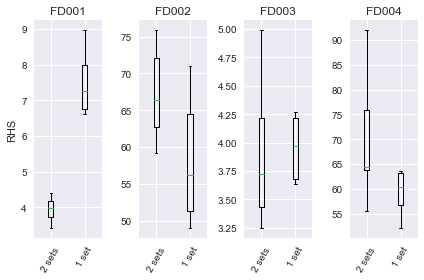

In [2]:
data = np.genfromtxt('results/scores_all_datasets.csv', delimiter=',')

data_rmse = [] 
data_rhs = []

print(data[0])

for dataset in range(4):
    
    #data_rmse.append([data[dataset*3], data[dataset*3+12], data[dataset*3+24]]) 
    #data_rhs.append([data[dataset*3+1], data[dataset*3+13], data[dataset*3+25]])
    
    data_rmse.append([data[dataset*3], data[dataset*3+12]]) 
    data_rhs.append([data[dataset*3+1], data[dataset*3+13]])


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#f.suptitle('Different sets of data-related parameters')
plt_ax = [ax1, ax2, ax3, ax4]
count = 0

for data_plot in data_rmse:
    plt_ax[count].boxplot(data_plot, showfliers=False)
    plt.sca(plt_ax[count])
    locs, _ = plt.xticks()
    plt.xticks(locs, ['2 sets', '1 set'], rotation=60)
    if count == 0:
        plt_ax[count].set_ylabel('RMSE')
        
    plt_ax[count].set_title('FD00'+str(count+1))
    count = count + 1 

f.tight_layout()
plt.savefig('rmse_comparisson.svg', bbox_inches='tight', format='svg')
plt.savefig('rmse_comparisson.png', bbox_inches='tight')

plt.clf()
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#f.suptitle('Different sets of data-related parameters')
plt_ax = [ax1, ax2, ax3, ax4]

count = 0
for data_plot in data_rhs:
    plt_ax[count].boxplot(data_plot, showfliers=False)
    plt.sca(plt_ax[count])
    locs, _ = plt.xticks()
    plt.xticks(locs, ['2 sets', '1 set'], rotation=60)
    if count == 0:
        plt_ax[count].set_ylabel('RHS')
        
    plt_ax[count].set_title('FD00'+str(count+1))
    count = count + 1 

f.tight_layout()
plt.savefig('rhs_comparisson.svg', bbox_inches='tight', format='svg')
plt.savefig('rhs_comparisson.png', bbox_inches='tight')


In [2]:
# load json and create model
json_file = open('bestRULModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("bestRULModel.h5")
print("Loaded model from disk")


#Shared parameters for the models
optimizer = Adam(lr=0, beta_1=0.5)
lossFunction = "mean_squared_error"
metrics = ["mse"]

#Selected as per CNN paper
selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'htBleed', 'W31', 'W32']

windowSize = 15
stride = 2
constRUL = 95


dataFolder = '../CMAPSSData'

#Create and compile the models
#nFeatures = len(selected_features)
#shapeSN = nFeatures*windowSize
#modelRULSN = RULmodel_SN_1(shapeSN)
loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

tModel = TunableModel('Loaded_Model', loaded_model, selected_features, dataFolder, window_size=windowSize,
                      scaler = min_max_scaler, window_stride=stride, constRul = constRUL)
tModel.loadData(verbose=1)
tModel.getModelDescription()


Loaded model from disk
Loading data for dataset 1 with window_size of 15, stride of 2 and constRUL of 95. Cros-Validation ratio 0
Data loaded for dataset 1
Description for model: Loaded_Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 30)                6330      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 10)                310       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
out (Dense)                  (None, 1)                 11        
Total params: 6,651
Trainable params: 6,651
Non-trainable params: 0
______________

In [3]:
# evaluate loaded model on test data
tModel.evaluateModel(["rhs"], round=2)
print("scores")

#print(tModel.y_pred)

cScores = tModel.scores
rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
rhs = cScores['rhs']
time = tModel.trainTime

i = 1
for prediction in tModel.y_pred:
    print('Engine {}, RUL {}, Rectified RUL {}, Real RUL {}'.format(i, prediction, 
                                                                    tModel.y_pred_rectified[i-1], 
                                                                    tModel.y_test[i-1]))
    i = i+1

print(cScores)
print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("RHS: {}".format(rhs))
print("Time : {} seconds".format(time))

100/100 [==============================] - 0s 868us/step
scores
Engine 1, RUL [ 104.33032227], Rectified RUL [ 104.], Real RUL [ 112.]
Engine 2, RUL [ 99.15076447], Rectified RUL [ 99.], Real RUL [ 98.]
Engine 3, RUL [ 59.42014694], Rectified RUL [ 59.], Real RUL [ 69.]
Engine 4, RUL [ 75.8947525], Rectified RUL [ 75.], Real RUL [ 82.]
Engine 5, RUL [ 81.05105591], Rectified RUL [ 81.], Real RUL [ 91.]
Engine 6, RUL [ 89.95090485], Rectified RUL [ 89.], Real RUL [ 93.]
Engine 7, RUL [ 87.58908844], Rectified RUL [ 87.], Real RUL [ 91.]
Engine 8, RUL [ 84.60612488], Rectified RUL [ 84.], Real RUL [ 95.]
Engine 9, RUL [ 99.2288208], Rectified RUL [ 99.], Real RUL [ 111.]
Engine 10, RUL [ 75.04779816], Rectified RUL [ 75.], Real RUL [ 96.]
Engine 11, RUL [ 68.72616577], Rectified RUL [ 68.], Real RUL [ 97.]
Engine 12, RUL [ 77.05379486], Rectified RUL [ 77.], Real RUL [ 124.]
Engine 13, RUL [ 70.40439606], Rectified RUL [ 70.], Real RUL [ 95.]
Engine 14, RUL [ 77.76304626], Rectified RUL 

In [16]:
def plotRUL(cycles, rulArray, engineUnit):
    
    plt.clf()
    plt.plot(cycles, rulArray, 'bo-', label='RUL')
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    
    plt.show()
    
def plotRUL_Engine(tModel, engineUnit):

    time_window = tModel.windowSize
    constRUL = tModel.constRul
    stride = tModel.windowStride
    selectedFeatures = tModel.selectedFeatures
    
    df = tModel.df_train
    df_engine = df.loc[df['Unit Number'] == engineUnit, :]
    df_engine['Unit Number'] = 1
    
    X_test2, _, _, _ = CMAPSAuxFunctions.create_windowed_data(df_engine, selected_features, 'train', time_window=time_window, 
                                                     constRUL=constRUL, stride=stride)
    
    X_test2 = tModel.dataScaler.transform(X_test2)
    nnPred = tModel.model.predict(X_test2)
    
    maxCycle = X_test2.shape[0]
    faultCycle = tModel.y_test[engineUnit-1]
    cycles = np.arange(maxCycle)
    rulArray = np.arange(faultCycle, maxCycle+faultCycle)
    rulArray[rulArray > constRUL] = constRUL
    rulArray = np.flipud(rulArray)
    
    plotRUL(cycles, rulArray, engineUnit)
    plt.plot(cycles, nnPred, 'go-', label='NN Pred')
    plt.legend()

/Users/davidlaredorazo/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Unit Number,Cycle,Op. Settings 1,Op. Settings 2,Op. Settings 3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
4168,1,1,-0.0017,-0.0005,100.0,518.67,642.24,1582.88,1410.66,14.62,...,2388.06,8128.48,8.4181,0.03,395,2388,100.0,38.90,23.3554,125.0
4169,1,2,-0.0013,0.0004,100.0,518.67,642.27,1582.13,1404.54,14.62,...,2388.05,8120.15,8.3895,0.03,392,2388,100.0,38.81,23.2300,125.0
4170,1,3,0.0025,-0.0003,100.0,518.67,642.47,1589.73,1408.88,14.62,...,2388.12,8124.89,8.4454,0.03,392,2388,100.0,38.69,23.3471,125.0
4171,1,4,0.0013,-0.0003,100.0,518.67,642.50,1587.18,1409.45,14.62,...,2388.08,8126.21,8.3913,0.03,393,2388,100.0,39.00,23.4179,125.0
4172,1,5,-0.0006,-0.0002,100.0,518.67,642.21,1596.51,1401.46,14.62,...,2388.10,8130.92,8.4825,0.03,393,2388,100.0,38.88,23.2637,125.0
4173,1,6,0.0061,0.0000,100.0,518.67,642.37,1592.15,1401.04,14.62,...,2387.98,8130.70,8.4145,0.03,391,2388,100.0,38.95,23.4954,125.0
4174,1,7,-0.0009,0.0004,100.0,518.67,642.45,1593.79,1397.77,14.62,...,2388.10,8134.62,8.4465,0.03,392,2388,100.0,38.94,23.3536,125.0
4175,1,8,0.0016,0.0002,100.0,518.67,642.44,1585.67,1407.80,14.62,...,2388.06,8129.22,8.4318,0.03,392,2388,100.0,38.91,23.3867,125.0
4176,1,9,0.0001,-0.0004,100.0,518.67,641.91,1590.36,1402.62,14.62,...,2388.10,8127.36,8.4487,0.03,391,2388,100.0,39.03,23.2562,125.0
4177,1,10,-0.0055,-0.0002,100.0,518.67,642.25,1582.71,1404.60,14.62,...,2388.09,8128.64,8.4286,0.03,392,2388,100.0,38.81,23.2975,125.0


/Users/davidlaredorazo/Documents/University of California/Research/Projects/NASA_RUL_(CMAPS)/code/CMAPSAuxFunctions.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['RUL'] = df.apply(compute_training_RUL, axis = 1, args=(rul_vector,constRUL,))


from aux functions
1
[195]
(91, 210)


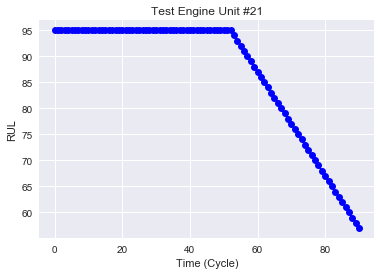

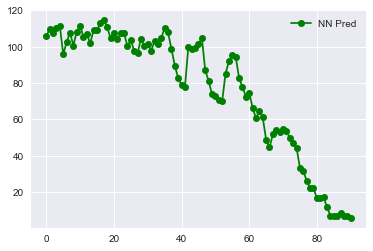

In [17]:
plotRUL_Engine(tModel, 21)